In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl

from cycler import cycler

import arch
from arch import arch_model
plt.style.use("seaborn")

In [2]:
print (arch.__version__)

4.19


A GARCH($1$, $1$) model for realized monthly volatility is given by:

$$
\begin{align*}
r_{t} &= \mu + \phi r_{t-1} + \sigma_{t}e_{t} \\
\sigma_{t}^2 &= \omega + \alpha \epsilon_{t-1}^2 +  \beta \sigma_{t-1}^2 \\
\epsilon_{t}&=\sigma_{t}e_{t}\\
e_{t} & \overset{i.i.d.}{\sim} N(0,1)
\end{align*}
$$

where as noted earlier and in lecture, $\sigma_{t}^2$ is known at time $t-1$ (i.e. it is deterministic). Also, $\sigma_{t}$ and $e_{t}$ are statistically independent. 

Using the `arch` package, which among many things provides estimation routines for univariate volatility models (see [online documentation](https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html)), the model constructor is given by `arch.arch_model` with a GARCH($1$, $1$) model being the default constructor.

To estimate a general GARCH($p$, $q$) model we need to pass additional arguments. 
Specifically, we need to pass: 
* name of the mean model: `mean` 
* lag length: `lags`
* name of the volatility model: `vol`
* lag order of the symmetric innovation: `p`
* lag order of lagged volatility: `q`. 

There are additional arguments we can pass, such as lag order of the asymmetric innovation, which is zero here (`o=0`), as well as the name of the error $e_t$ distribution, which is assumed to be Normal (`dist`=`Normal`). Since the defaults in place are in accordance with our model assumptions, we are not required to pass these arguments. Also, we can display the likelihood estimation convergence information (set `disp` to `on` or `off` in subroutine `summary()` after `fit()` has been executed).

#### Forecasting:
The `arch` package provides a rich set of forecasting tools (see [online documentation](https://arch.readthedocs.io/en/latest/univariate/forecasting.html)). There are three types of forecasts:
1. **Analytical**: analytical forecasts are always available for the 1-step ahead forecast due to the structure of ARCH-type models. Multi-step analytical forecasts are only available for model which are linear in the square of the residual, such as GARCH or HARCH.
2. **Simulation-based**: simulation-based forecasts are always available for any horizon, although they are only useful for horizons larger than 1 since the first out-of-sample forecast from an ARCH-type model is always fixed. Simulation-based forecasts make use of the structure of an ARCH-type model to forward simulate using the assumed distribution of residuals, e.g., a Normal or Student’s $t$.
3. **Bootstrapped**: bootstrap-based forecasts are similar to simulation based forecasts except that they make use of the standardized residuals from the actual data used in the estimation rather than assuming a specific distribution. Like simulation-base forecasts, bootstrap-based forecasts are only useful for horizons larger than 1. Additionally, the bootstrap forecasting method requires a minimal amount of in-sample data to use prior to producing the forecasts.

Given the relative simplicity of the models we will analyze, we can use Analytical forecasts. 


We can write a "wrapper" that constructs a general model instance, plots the volatility and standardized residuals, stores parameters, runs forecasts, etc. 

In [3]:
def arch_model_est(y, y_RV, ARCHModel_dict, max_horizon, train_enddt=None, test_startdt=None, summarize=True, 
                   plot_vol_measures=True, plot_forecast=None, model_name='', annualize=True, sim_t = 1000,
                   y_title = 'Return (%)', x_title ='Years',y_RV_title = 'Realized Vol $(\sigma_{t+1})$',
                   y_RV_label = '$RV_{t} =\sigma_{t+1}$'):
    """
    Wrapper to constructs a general model instance, plots the volatility and standardized residuals, 
    stores parameters, runs forecasts for GARCH models.
    
    Args:
        y: DataFrame, observed process for full sample.
        y_Rv: DataFrame, observed realized volatility of the observed process for the full sample.
        ARCHModel_dict: dict, parameter values for arguments used to construct a model instance and 
                        other estimation arguments.
        train_enddt: datetime or None, date of last observation used in training/estimation sample.
        test_startdt: datetime or None, date of first observation (exclusively) used in testing/forecasting sample.
        summarize: bool, display estimation summary or not.
        plot_vol_measures: bool, plot the following or not:
                             1. estimated conditional volatility, 
                             2. 1-step ahead forecasted conditional volatility
                             3. realized volatility
        annualize: bool, volatility measures (observed or estimated) are annualized or not.
    """
    ### Training sample    
    am = arch_model(y, mean=ARCHModel_dict['mean'], lags=ARCHModel_dict['lags'], vol=ARCHModel_dict['vol'], 
                       p=ARCHModel_dict['p'], o=ARCHModel_dict['o'], q=ARCHModel_dict['q'], 
                       dist=ARCHModel_dict['dist'])

    if train_enddt==None:                    
        am_est = am.fit(disp=ARCHModel_dict['disp'])
    else:
        am_est = am.fit(disp=ARCHModel_dict['disp'], last_obs=train_enddt)

    am_dict = ARCHModel_dict.copy()
    am_dict['bic'] = am_est.bic 
    am_dict['log-likelihood'] = am_est.loglikelihood
    am_dict['params'] = am_est.params
    am_dict['cond_vol'] = am_est.conditional_volatility

    if summarize:
        print('\n**** '+y.name+' ****\n\n', am_est.summary(), 'n')   

    ### h-step ahead forecasts
    if test_startdt==None:    
        am_rv_forecasts_h = (am_est.forecast(horizon=max_horizon, align='target', 
                                             method='simulation', simulations=100).variance)**0.5
    else:    
        am_rv_forecasts_h = (am_est.forecast(horizon=max_horizon, align='target', start=test_startdt).variance)**0.5           
    
    # simulate data
    am_dict['sim_data']   = am.simulate(am_est.params.values, sim_t)
        
    ### MSE, RMSE, & MAE     
    MSE, RMSE, MAE = {}, {}, {}  
    for h in range(1, max_horizon+1):
        if max_horizon >= 10:
            if max_horizon >= 100:
                error_h = (y[test_startdt] - am_rv_forecasts_h['h.'+"{0:0=3d}".format(h)]).dropna()
            else:
                error_h = (y[test_startdt] - am_rv_forecasts_h['h.'+"{0:0=2d}".format(h)]).dropna()
        else:
            error_h = (y[test_startdt] - am_rv_forecasts_h['h.'+str(h)]).dropna()
        T_h = len(error_h) 
        MSE[h] = (1/T_h)*np.sum(error_h**2)
        RMSE[h] = ((1/T_h)*np.sum(error_h**2))**0.5
        MAE[h] = (1/T_h)*np.sum(np.abs(error_h)) 
        
    am_dict['max_forecast_h'] = max_horizon
    am_dict['rv_forecasts_h'] = am_rv_forecasts_h
    am_dict['MSE'] = MSE
    am_dict['RMSE'] = RMSE
    am_dict['MAE'] = MAE
                    
    if annualize:
        a_label = '$\\bf{annualized}$'
        if ARCHModel_dict['freq']=='D':
            scale = 252**0.5
        elif ARCHModel_dict['freq']=='M':
            scale = 12**0.5
    else:
        a_label = '$\\bf{annualized}$'
        scale = 1
                
    if plot_vol_measures:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8))     
        axes.plot(scale*y_RV, lw=0.75, label=y_RV_label)
        axes.plot(scale*am_est.conditional_volatility, lw=1.5, ls='--',
                  label='$'+model_name+'$: $\widehat{\sigma}_{t+1}$')
        if plot_forecast != None:
            if max_horizon >= 10:
                if max_horizon >= 100:
                    axes.plot(scale*am_rv_forecasts_h['h.'+"{0:0=3d}".format(plot_forecast)], lw=1.5, alpha=.5,
                              label='$'+model_name+'$: $E_t[\widehat{\sigma}_{t+'+str(plot_forecast)+'}]$')
                else:
                    axes.plot(scale*am_rv_forecasts_h['h.'+"{0:0=2d}".format(plot_forecast)], lw=1.5, alpha=.5,
                              label='$'+model_name+'$: $E_t[\widehat{\sigma}_{t+'+str(plot_forecast)+'}]$')
            else:
                axes.plot(scale*am_rv_forecasts_h['h.'+"{0:0=1d}".format(plot_forecast)], lw=1.5, alpha=.5,
                              label='$'+model_name+'$: $E_t[\widehat{\sigma}_{t+'+str(plot_forecast)+'}]$')
        axes.set_xlabel(x_title, fontsize=18)
        axes.set_ylabel(y_title, fontsize=18)
        #title_label = 'log '+y.name+' returns:\n'+a_label+'\nRealized Vol $(\sigma_{t+1})$,' +\
        #              '\nEstimated Conditional Vol $(\widehat{\sigma}_{t+1})$'+\
        #              '\n$Forecasted$ $(h='+str(1)+')$ Realized Vol $(\sigma_{t+h|t})$' 
        if plot_forecast != None:
            title_label = 'log '+y.name+' returns:\n'+y_RV_title+\
                '\nEstimated Conditional Vol $(\widehat{\sigma}_{t+1})$'+\
            '\n$Forecasted$ $(h='+str(plot_forecast)+')$ Realized Vol $(\sigma_{t+h|t})$'
        else:
            title_label = 'log '+y.name+' returns:\n'+y_RV_title+\
                      '\nEstimated Conditional Vol $(\widehat{\sigma}_{t+1})$'
        axes.set_title(title_label, fontsize=18)
        axes.legend(fontsize=16, loc='best')   
        fig.tight_layout()         
        
    return am_dict

In [4]:
df = pd.read_csv('../data/df2.csv')
df.head()

,Y1,Y2,Y3
0,0.071274,0.071274,0.194379
1,-0.039769,-0.039769,-0.129037
2,-0.045807,-0.045807,-0.097470
3,0.058358,0.058358,0.089315
4,-0.044413,-0.044413,-0.072146


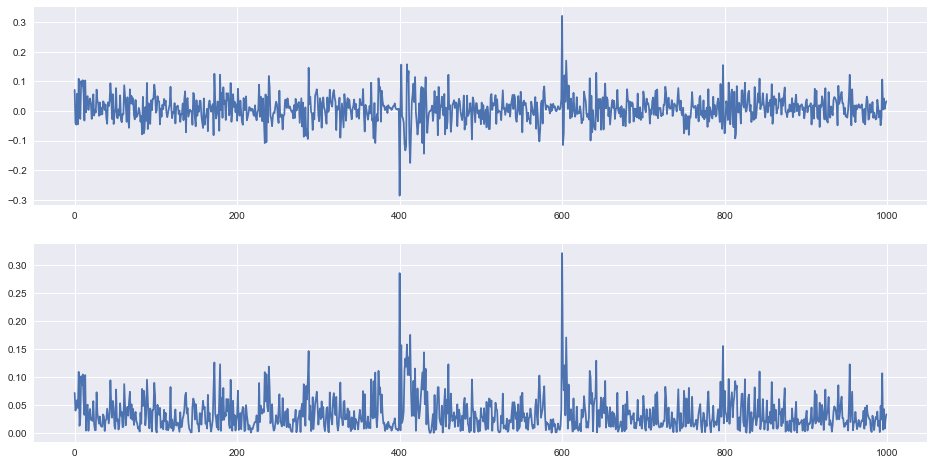

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,8))  
axes[0].plot(df['Y1'])
axes[1].plot(np.abs(df['Y1']))
plt.show()

### Example: Estimate an ARCH(1) for Y1

D:\anaconda3\envs\mfestats\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002019. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
D:\anaconda3\envs\mfestats\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,



**** Y1 ****

                       Constant Mean - ARCH Model Results                      
Dep. Variable:                     Y1   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                1712.16
Distribution:                  Normal   AIC:                          -3418.33
Method:            Maximum Likelihood   BIC:                          -3403.60
                                        No. Observations:                 1000
Date:                Mon, Aug 02 2021   Df Residuals:                      999
Time:                        21:27:43   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.9063e-03  1.289e-03      6.13

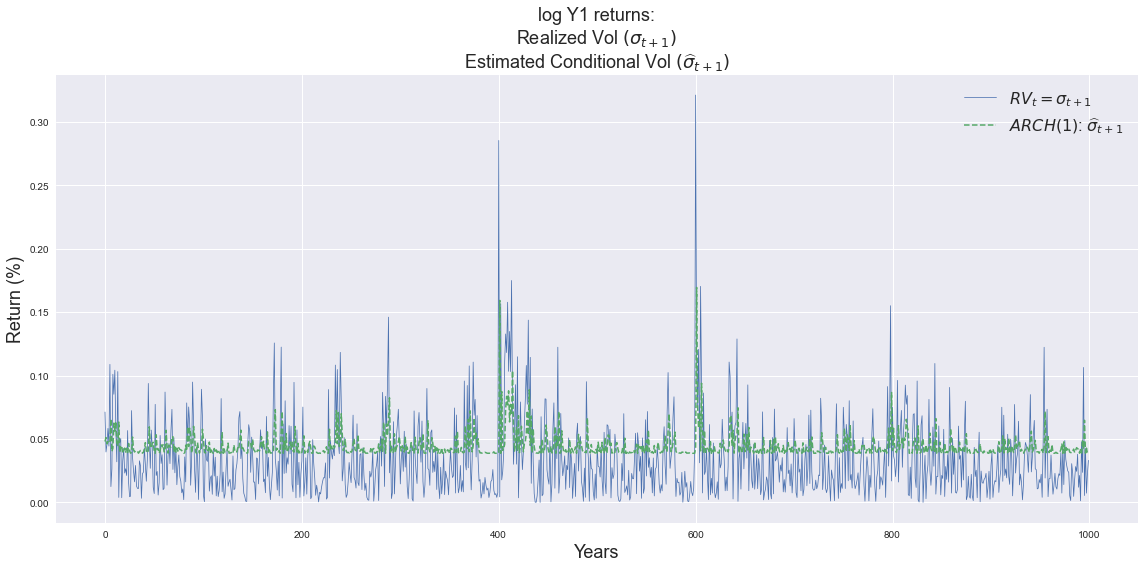

In [6]:
Params = pd.DataFrame(index=['mu', 'omega','omega1', 'alpha[1]', 'alpha[2]', 'alpha[3]', 'alpha[4]',
                             'gamma[1]', 'beta[1]'])

arch_dict   = {'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 0, 'dist': 'Normal', 
                'freq': 'M', 'disp': 'off'}

train_enddt  = None
test_startdt = df['Y1'].index.min()

arch_dict1   = arch_model_est(y=df['Y1'], y_RV=np.abs(df['Y1']), ARCHModel_dict=arch_dict,
                                  max_horizon=5, test_startdt=test_startdt, model_name='ARCH(1)',
                                  annualize=False)

lbl = arch_dict1['vol']+'('+str(arch_dict1['p'])+','+str(arch_dict1['o'])+','+str(arch_dict1['q'])+')'
Params[lbl] = arch_dict1['params']


### Example: Estimate an ARCH(4) for Y1

D:\anaconda3\envs\mfestats\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002019. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
D:\anaconda3\envs\mfestats\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,



**** Y1 ****

                       Constant Mean - ARCH Model Results                      
Dep. Variable:                     Y1   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                1728.18
Distribution:                  Normal   AIC:                          -3444.36
Method:            Maximum Likelihood   BIC:                          -3414.91
                                        No. Observations:                 1000
Date:                Mon, Aug 02 2021   Df Residuals:                      999
Time:                        21:27:43   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.2805e-03  1.247e-03      6.63

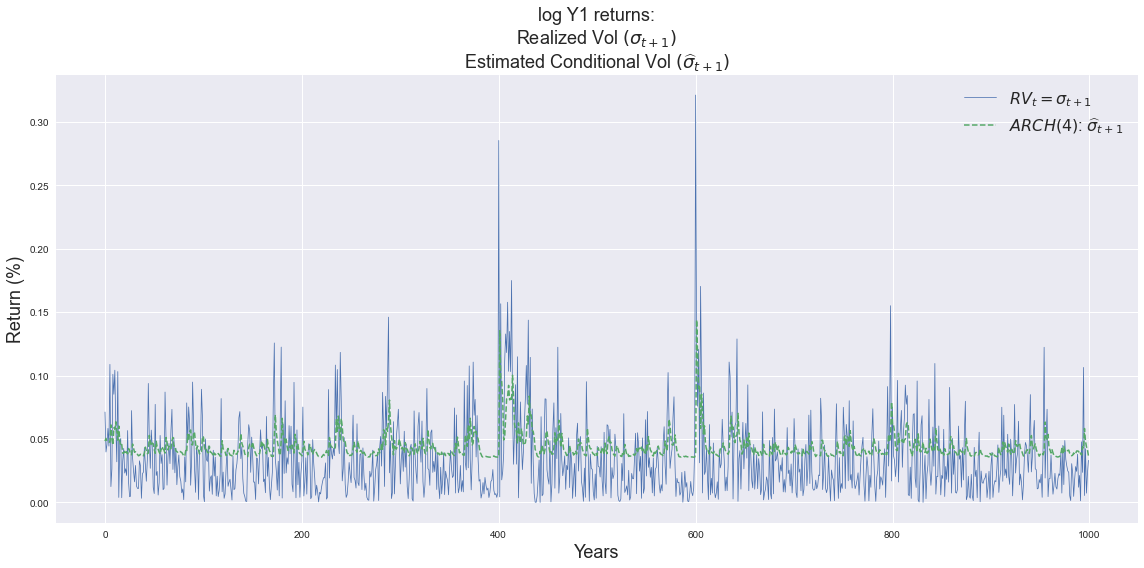

In [7]:
arch4_dict   = {'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 4, 'o': 0, 'q': 0, 'dist': 'Normal', 
                'freq': 'M', 'disp': 'off'}

train_enddt  = None
test_startdt = df['Y1'].index.min()

arch4_dict1   = arch_model_est(y=df['Y1'], y_RV=np.abs(df['Y1']), ARCHModel_dict=arch4_dict, 
                                    max_horizon=5, test_startdt=test_startdt, model_name='ARCH(4)', annualize=False)

lbl = arch4_dict1['vol']+'('+str(arch4_dict1['p'])+','+str(arch4_dict1['o'])+','+str(arch4_dict1['q'])+')'
Params[lbl] = arch4_dict1['params']

### Example: Estimate a GARCH(1,1) for Y1

D:\anaconda3\envs\mfestats\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002019. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
D:\anaconda3\envs\mfestats\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,



**** Y1 ****

                      Constant Mean - GARCH Model Results                      
Dep. Variable:                     Y1   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1728.97
Distribution:                  Normal   AIC:                          -3449.94
Method:            Maximum Likelihood   BIC:                          -3430.31
                                        No. Observations:                 1000
Date:                Mon, Aug 02 2021   Df Residuals:                      999
Time:                        21:27:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.3332e-03  1.234e-03      6.75

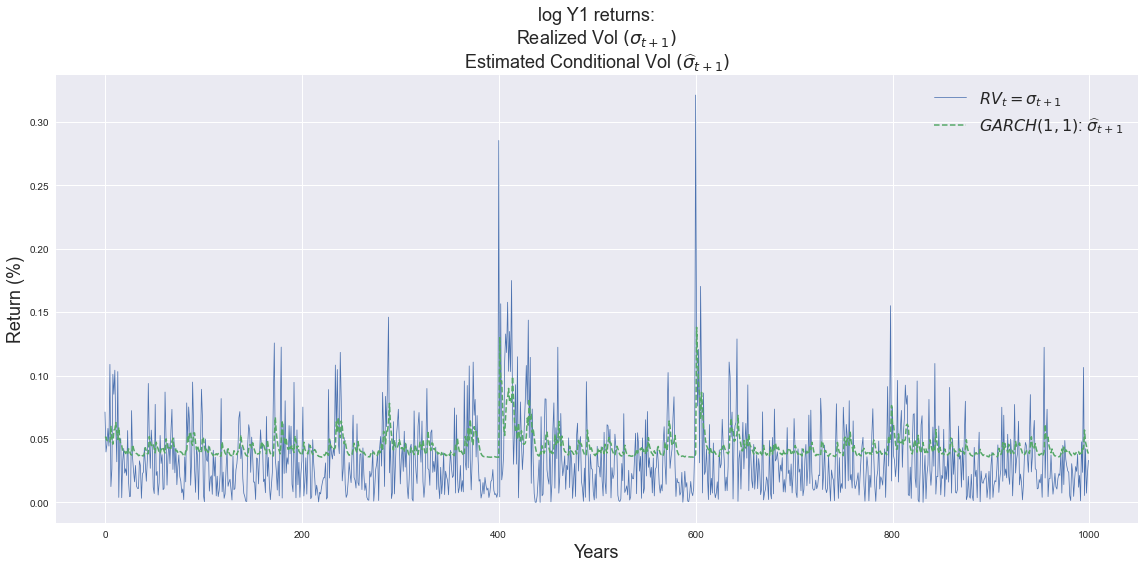

In [8]:
garch_dict  = {'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 'Normal', 
                'freq': 'M', 'disp': 'off'}

train_enddt  = None
test_startdt = df['Y1'].index.min()

garch_dict1  = arch_model_est(y=df['Y1'], y_RV=np.abs(df['Y1']), ARCHModel_dict=garch_dict, 
                                    max_horizon=5, test_startdt=test_startdt, model_name='GARCH(1,1)', annualize=False)

lbl = garch_dict1['vol']+'('+str(garch_dict1['p'])+','+str(garch_dict1['o'])+','+str(garch_dict1['q'])+')'
Params[lbl] = garch_dict1['params']

### Example: Estimate a GJR-GARCH( 1 , 1 ) for Y1

D:\anaconda3\envs\mfestats\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002019. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
D:\anaconda3\envs\mfestats\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,



**** Y1 ****

                    Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                     Y1   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                1732.90
Distribution:                  Normal   AIC:                          -3455.79
Method:            Maximum Likelihood   BIC:                          -3431.25
                                        No. Observations:                 1000
Date:                Mon, Aug 02 2021   Df Residuals:                      999
Time:                        21:27:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.5168e-03  1.318e-03      5.70

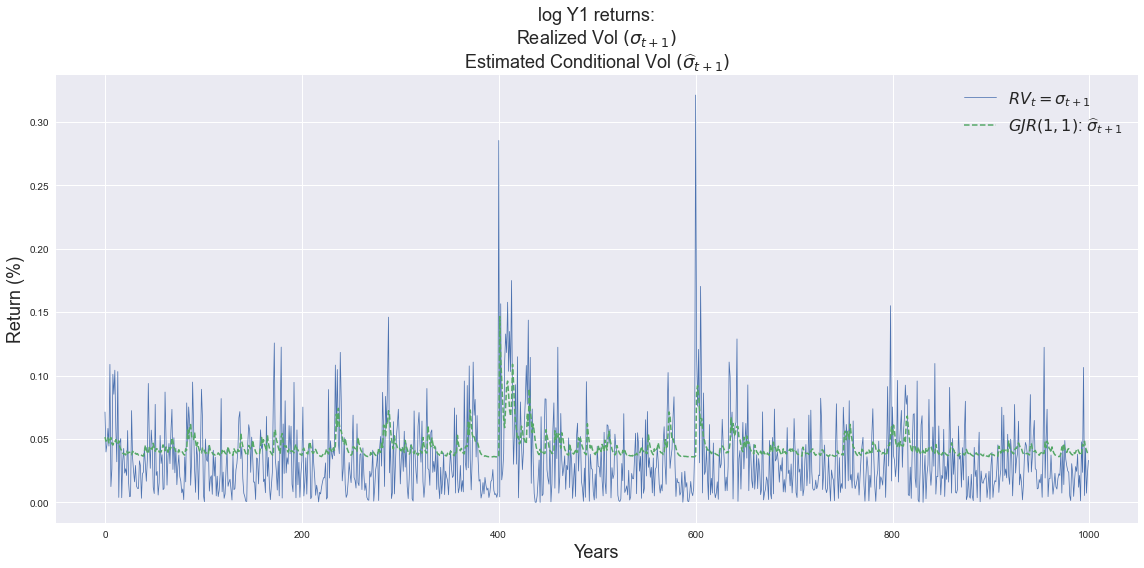

In [9]:
GJR_dict1_ = {'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 1, 'q': 1, 'dist': 'Normal', 
                'freq': 'M', 'disp': 'off'}

train_enddt = None
test_startdt = df['Y1'].index.min()

GJR_dict1 = arch_model_est(y=df['Y1'], y_RV=np.abs(df['Y1']), ARCHModel_dict=GJR_dict1_, 
                                    max_horizon=5, test_startdt=test_startdt, model_name='GJR(1,1)', annualize=False)

lbl = GJR_dict1['vol']+'('+str(GJR_dict1['p'])+','+str(GJR_dict1['o'])+','+str(GJR_dict1['q'])+')'
Params[lbl] = GJR_dict1['params']

### Example: Forecasted volatility at different horizons

Now compare h-ahead **in-sample** forecast and true volatility.

In [10]:
df_sig = pd.read_csv('../data/df2_sig.csv')
df_sig.head()

,Y1,Y2,Y3
0,0.032538,0.032538,0.097910
1,0.036927,0.036927,0.103162
2,0.043926,0.043926,0.084590
3,0.049885,0.049885,0.081819
4,0.046383,0.046383,0.070023


In [11]:
garch11_dict = {'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 'Normal', 
                'freq': 'M', 'disp': 'off'}

test_startdt = df['Y1'].index.min()
max_horizon = 10

gjr11_IXIC_dict1 = arch_model_est(y=df['Y1'], y_RV=df_sig['Y1'], ARCHModel_dict=garch11_dict,
                                      summarize = False,max_horizon=max_horizon,plot_forecast=None,
                                      plot_vol_measures=False,test_startdt=test_startdt,
                                      model_name='GARCH(1,1)', annualize=False,
                                      y_RV_title = 'True $\sigma_{t+1}$', y_RV_label = 'True $\sigma_{t+1}$',
                                      x_title = 'Period', y_title = '$\sigma_{t+1}$')

D:\anaconda3\envs\mfestats\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002019. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
D:\anaconda3\envs\mfestats\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [12]:
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                                   '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                                   '#bcbd22', '#17becf'])

D:\anaconda3\envs\mfestats\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  after removing the cwd from sys.path.


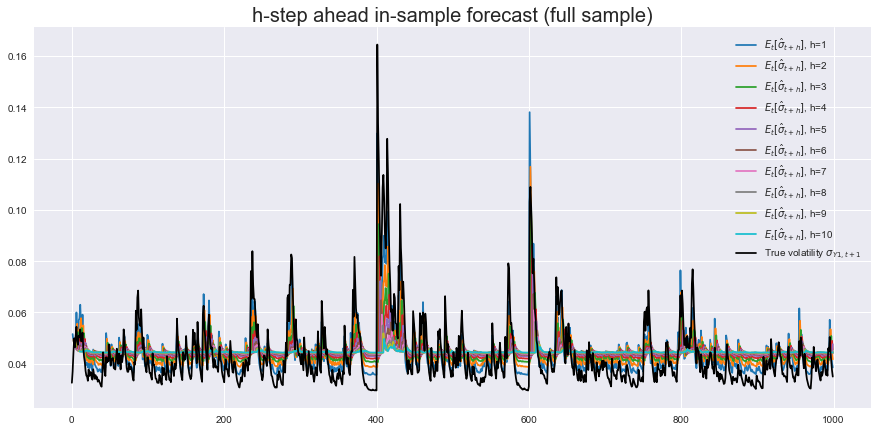

D:\anaconda3\envs\mfestats\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  from ipykernel import kernelapp as app


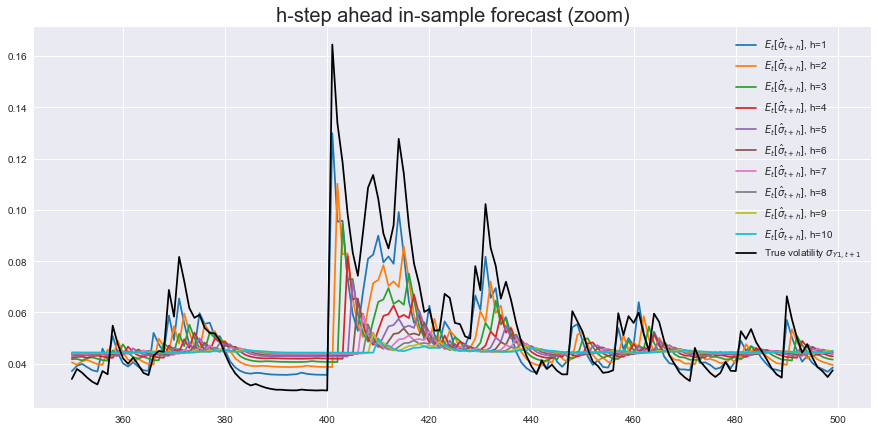

In [13]:
f = plt.figure(figsize=(15,7))
plt.plot(gjr11_IXIC_dict1['rv_forecasts_h'])
plt.plot(df_sig['Y1'],color='k')
plt.title('h-step ahead in-sample forecast (full sample)',FontSize=20)
leg = ['$E_t[\hat{\sigma}_{t+h}]$, h='+str(i) for i in range(1,max_horizon+1)]
leg.append('True volatility $\sigma_{Y1,t+1}$')
plt.legend(leg)
plt.show()

start = 350
end = 500
f = plt.figure(figsize=(15,7))
plt.plot(gjr11_IXIC_dict1['rv_forecasts_h'][start:end])
plt.plot(df_sig['Y1'][start:end],color='k')
plt.title('h-step ahead in-sample forecast (zoom)',FontSize=20)
leg = ['$E_t[\hat{\sigma}_{t+h}]$, h='+str(i) for i in range(1,max_horizon+1)]
leg.append('True volatility $\sigma_{Y1,t+1}$')
plt.legend(leg)
plt.show()

Now compare h-ahead out-of-sample forecast and true volatility.

D:\anaconda3\envs\mfestats\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002324. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  data_scale_warning.format(orig_scale, rescale), DataScaleWarning
D:\anaconda3\envs\mfestats\lib\site-packages\arch\__future__\_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
D:\anaconda3\envs\mfestats\lib\site-packages\arch\univariate\base.py:317: DataScaleWarning: y is 

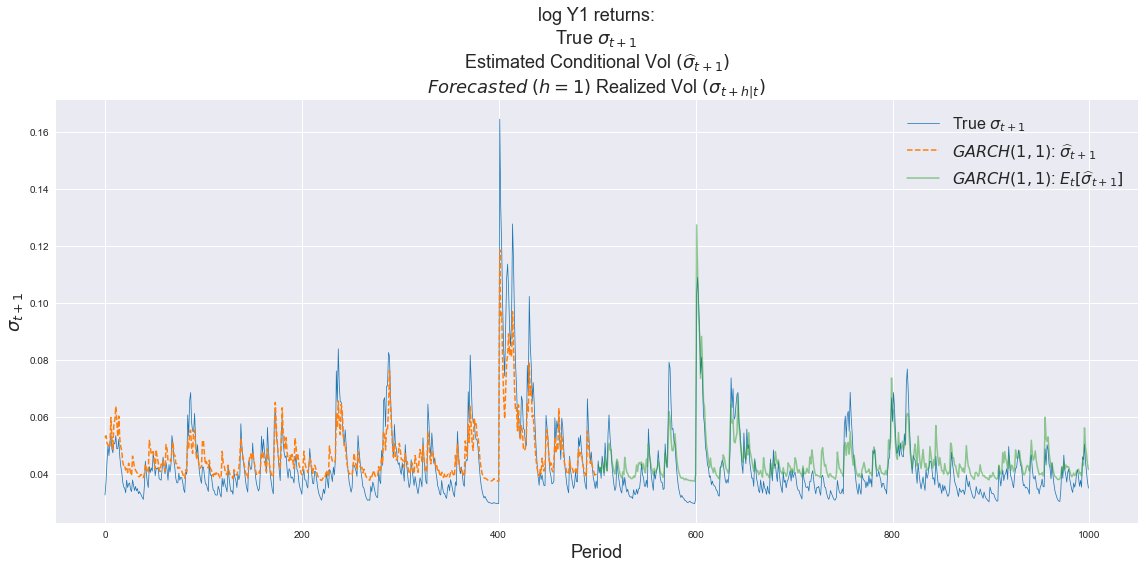

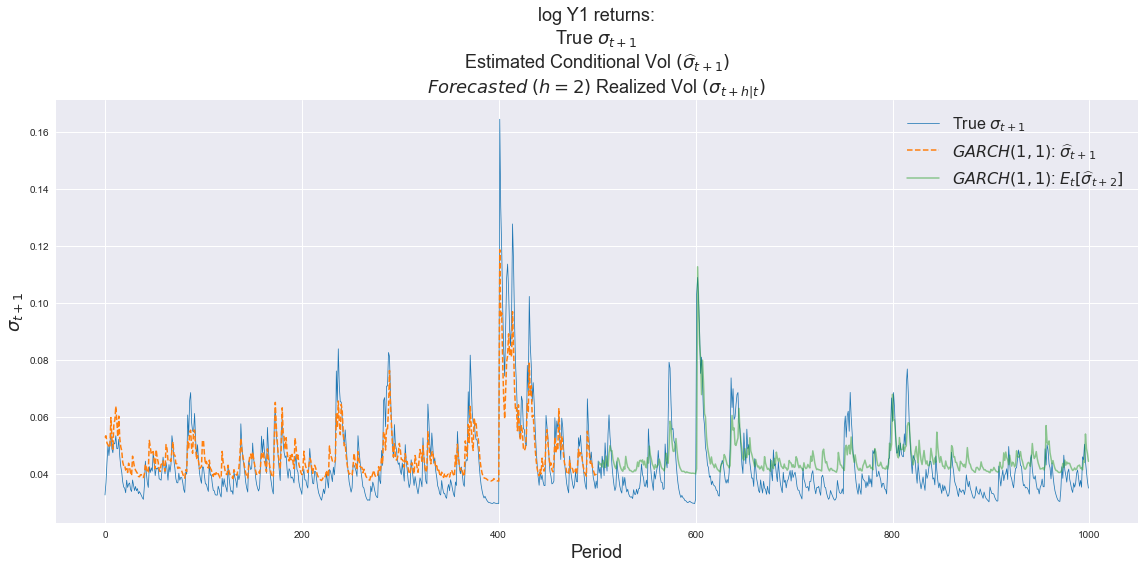

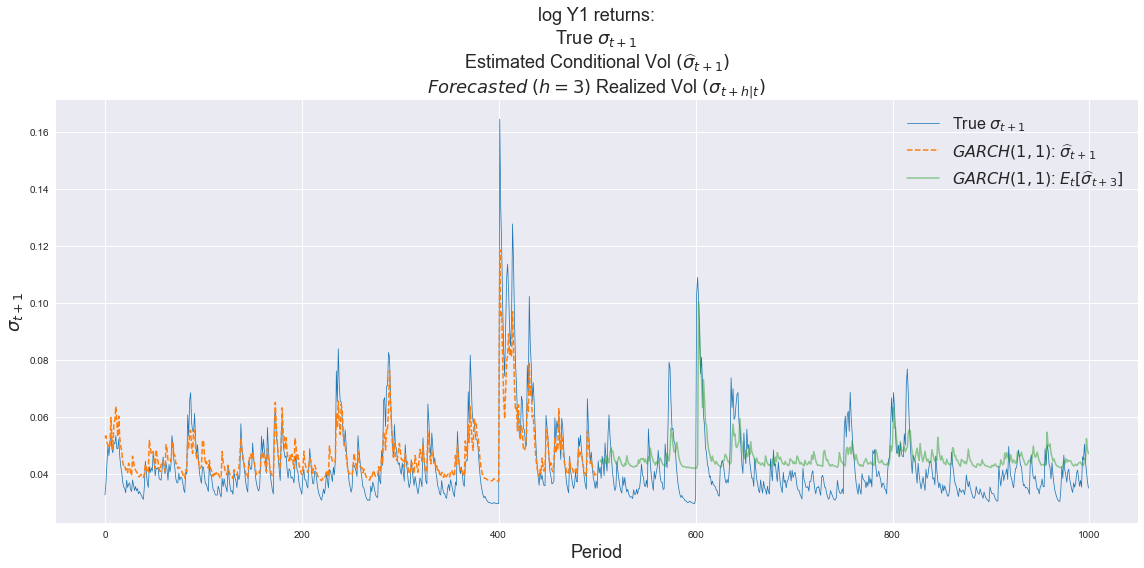

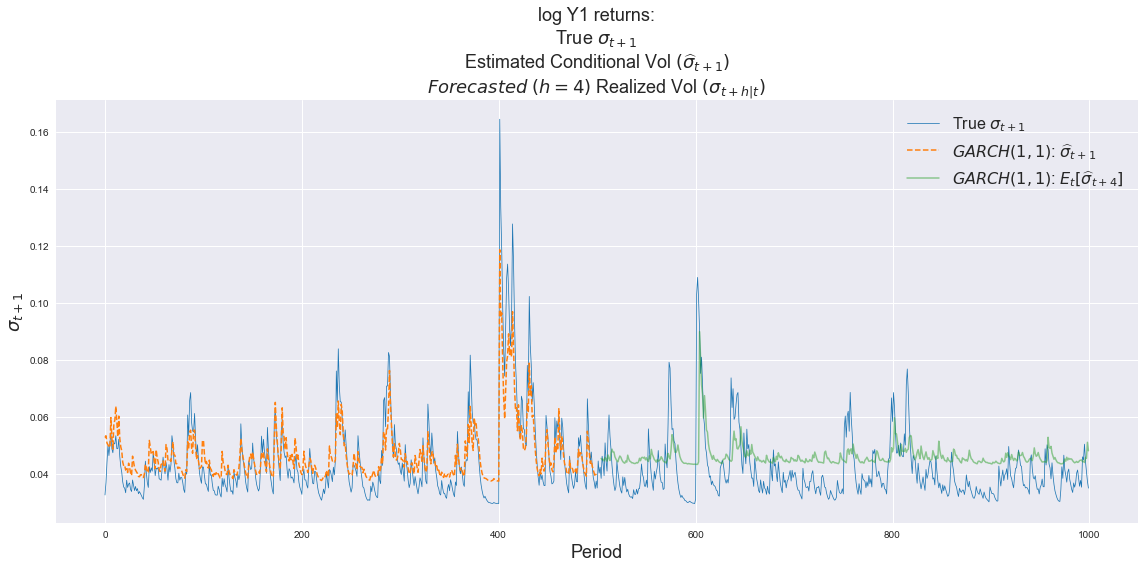

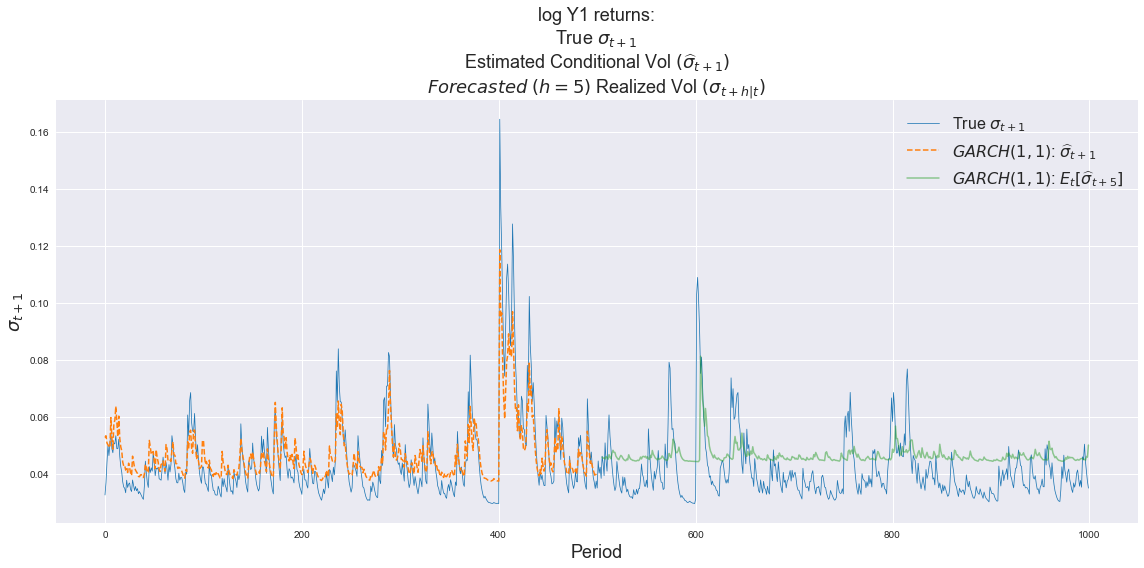

In [14]:
garch11_dict = {'mean': 'Constant', 'lags': 0, 'vol': 'GARCH', 'p': 1, 'o': 0, 'q': 1, 'dist': 'Normal', 
                'freq': 'M', 'disp': 'off'}

train_enddt = 500
test_startdt = 500
max_horizon = 5

for h in range(1,max_horizon+1):
    gjr11_IXIC_dict1 = arch_model_est(y=df['Y1'], y_RV=df_sig['Y1'], ARCHModel_dict=garch11_dict,
                                      summarize = False,max_horizon=max_horizon,plot_forecast=h,
                                      train_enddt = train_enddt, test_startdt = test_startdt,
                                      model_name='GARCH(1,1)', annualize=False,
                                      y_RV_title = 'True $\sigma_{t+1}$', y_RV_label = 'True $\sigma_{t+1}$',
                                      x_title = 'Period', y_title = '$\sigma_{t+1}$')

## GMM for Estimating GARCH(1, 1) Parameters

As above, we've just computed the estimation using MLE, but we can also use Generalized Method of Moments (GMM) to estimate the GARCH(1, 1) parameters.

To do this we need to define our moments. We'll use 4.

1. The residual $\hat\epsilon_t = x_t / \hat\sigma_t$
2. The variance of the residual $\hat\epsilon_t^2$
3. The skew moment $\mu_3/\hat\sigma_t^3 = (\hat\epsilon_t - E[\hat\epsilon_t])^3 / \hat\sigma_t^3$
4. The kurtosis moment $\mu_4/\hat\sigma_t^4 = (\hat\epsilon_t - E[\hat\epsilon_t])^4 / \hat\sigma_t^4$

Note that there are many ways to choose the moments we want to match, and many times we can get different results.

In [15]:
import cvxopt
from functools import partial
from scipy import stats

In [16]:
def compute_squared_sigmas(X, initial_sigma, theta):
    a0 = theta[0]
    a1 = theta[1]
    b1 = theta[2]
    T = len(X)
    sigma2 = np.ndarray(T)
    sigma2[0] = initial_sigma ** 2
    for t in range(1, T):
        # Here's where we apply the equation
        sigma2[t] = a0 + a1 * X[t-1]**2 + b1 * sigma2[t-1]
    
    return sigma2

In [17]:
def negative_log_likelihood(X, theta):
    T = len(X)
    # Estimate initial sigma squared
    initial_sigma = np.sqrt(np.mean(X ** 2))
    # Generate the squared sigma values
    sigma2 = compute_squared_sigmas(X, initial_sigma, theta)
    # Now actually compute
    return -sum(
        [-np.log(np.sqrt(2.0 * np.pi)) -
        (X[t] ** 2) / (2.0 * sigma2[t]) -
        0.5 * np.log(sigma2[t]) for
         t in range(T)]
    )

In [18]:
def constraint1(theta):
    return np.array([1 - (theta[1] + theta[2])])

def constraint2(theta):
    return np.array([theta[1]])

def constraint3(theta):
    return np.array([theta[2]])

# The n-th standardized moment
# skewness is 3, kurtosis is 4
def standardized_moment(x, mu, sigma, n):
    return ((x - mu) ** n) / (sigma ** n)

cons = ({'type': 'ineq', 'fun': constraint1},
        {'type': 'ineq', 'fun': constraint2},
        {'type': 'ineq', 'fun': constraint3})


### GMM Estimation Procedure

GMM now has three steps.

Start with $W$ as the identity matrix.

1. Estimate $\hat\theta_1$ by using numerical optimization to minimize

$$\min_{\theta \in \Theta} \left(\frac{1}{T} \sum_{t=1}^T g(x_t, \hat\theta)\right)' W \left(\frac{1}{T}\sum_{t=1}^T g(x_t, \hat\theta)\right)$$

2. Recompute $W$ based on the covariances of the estimated $\theta$. (Focus more on parameters with explanatory power)

$$\hat W_{i+1} = \left(\frac{1}{T}\sum_{t=1}^T g(x_t, \hat\theta_i)g(x_t, \hat\theta_i)'\right)^{-1}$$

3. Repeat until $|\hat\theta_{i+1} - \hat\theta_i| < \epsilon$ or we reach an iteration threshold.

Initialize $W$ and $T$ and define the objective function we need to minimize.

In [19]:
def gmm_objective(X, W, theta):
    # Compute the residuals for X and theta
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma
    
    # Compute the mean moments
    m1 = np.mean(e)
    m2 = np.mean(e ** 2) - 1
    m3 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 3))
    m4 = np.mean(standardized_moment(e, np.mean(e), np.std(e), 4) - 3)
    
    G = np.matrix([m1, m2, m3, m4]).T
    
    return np.asscalar(G.T * W * G)

def gmm_variance(X, theta):
    # Compute the residuals for X and theta    
    initial_sigma = np.sqrt(np.mean(X ** 2))
    sigma = np.sqrt(compute_squared_sigmas(X, initial_sigma, theta))
    e = X / sigma

    # Compute the squared moments
    m1 = e ** 2
    m2 = (e ** 2 - 1) ** 2
    m3 = standardized_moment(e, np.mean(e), np.std(e), 3) ** 2
    m4 = (standardized_moment(e, np.mean(e), np.std(e), 4) - 3) ** 2
    
    # Compute the covariance matrix g * g'
    T = len(X)
    s = np.ndarray((4, 1))
    for t in range(T):
        G = np.matrix([m1[t], m2[t], m3[t], m4[t]]).T
        s = s + G * G.T
    
    return s / T

In [21]:
# Initialize GMM parameters
W = np.identity(4)
#gmm_iterations = 2
gmm_iterations = 10
X = df['Y1']
# First guess
theta_gmm_estimate = [0.02, .2, .7]

In [ ]:
objective = partial(gmm_objective, X, W)
print(objective(theta_gmm_estimate))

# Perform iterated GMM
for i in range(gmm_iterations):
    # Estimate new theta
    objective = partial(gmm_objective, X, W)
    result = sp.optimize.minimize(objective, theta_gmm_estimate,
                                  constraints=sp.optimize.LinearConstraint([1,1,0], -np.inf, 1),
                                  bounds=sp.optimize.Bounds([0, 0, 0], [np.inf,np.inf, np.inf]),
                                  options={'disp': True, })
    theta_gmm_estimate = result.x
    print('Iteration ' + str(i) + ' theta: ' + str(theta_gmm_estimate))
    
    # Recompute W
    W = np.linalg.inv(gmm_variance(X, theta_gmm_estimate))